In [ ]:
# ASTR400B Research Assignment3
# Prof: G. Besla
# TA: R. Li
#Student: Yuxuan Chen

In [ ]:
#this project is to investigate the tidal evolution of M33's dark matter halo, emphasizing on two points: 1.mass loss 
#of dark matter, 2.change of internal dark matter profile.In this paper, I will study the change of M33's dark matter
#halo profile and internal dark matter profile during the period of M31 and M33's orbit evolution. I want to simulate 
#the outer/internal dark matter mass profile and internal density disk/dark matter halo profile of M33 based on the 
#simulation data of the merger of M31 and MW.I will create a program to compute Jacobi Radius and examine how much mass
#is outside this radius as function of time.Throught the change of Jacobi Radius, it can prove that M33 will lose dark 
#matter mass due to tides from M31. 

#Host mass will be calculated from each VLowRes files. The initial Jacobi mass will be the mass of M33, which from
#the first VLowRes file. After that,I will wirite a for loop to calculate host mass from each files, and
#use the racobi radius that we calculated from the previous file to find how much mass is in this radius as new JacobiMass
#Then,using the new Jacobi Mass and the hostmass to calculate the new Jacobi Radius. And repeated in the for loop.
#Then I will bring the initial Jacobi radius to second file, to see how much mass perparticle still in initial

#Setting If condition for initial Jacobi Radius.
#Setting another condition for when MW and M31 merged, and count MW mass which impact on M33 to host mass.
#1.we can plot jacobi radius vs time and Jacobi mass vs radius
#2.we can use MassProfile to plot the Mass profile(from class) for M33 Halo and Disk
#3.we can use stellar disk density function(from Rixin) to calculate M33 disk density profile
#4.Using Hernquist Mean Halo density to compare with Enclosed Mean Halo density(Thanks Rixin provided how to caculate the best scale radius)


In [1]:
# import modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# my modules
from ReadFile import Read
# Step 1: modify CenterOfMass so that COM_P now takes a parameter specifying 
# by how much to decrease RMAX instead of a factor of 2
from CenterOfMass2 import CenterOfMass
from MassProfile import MassProfile
#Thanks Rixin for providing how to calculate disk density
from diskmass import SurfaceDensityProfile
# scipy provides powerful least-square fitting procedure
from scipy.optimize import least_squares

In [2]:
'''I have write 2 fucntions here, which is simmilar to MassProfile.py. I here, MassEnclosed_M33 calculate
the mass of M33 in Jacobi Radius. MassEnclosed_M31 could calculate the mass in M31(adding MW after 6.5 gyr caused by merger)
that is in the range of host mass
    inputs: filename1 is only for M33 files that we read from VLowRes document
            filename2 is only for M31 files that we read from VLowRes document
            filename3 is only for MW files that we read from VLowRes document, after the merger
            ptype 1.halo 2.disk 3.bulge
            Rg has 2 situation, depends on what we want to calcualte
            Rg is the distance from COM of M33 and M31(M33 and MW), if we calculate host mass
            Rg could also be Jacobi radius, if we calculate Jacobi Mass of M33
            COM1_position, is from COM position for the running filename 
            '''
def MassEnclosed_M33(filename1, ptype, Rg, COM1_position):
    # Store the the position of COM for M33
    time, total, data = Read(filename1)
    index = np.where(data['type'] == ptype)
    x = data['x'][index]
    y = data['y'][index]
    z = data['z'][index]
    m = data['m'][index]
    # Read the file from VLowRes
    # Store positions and mass of particles of given ptype 
    xG = x - COM1_position[0]
    yG = y - COM1_position[1]
    zG = z - COM1_position[2]
    # Compute the magnitude of radius to COM
    rG = np.sqrt(xG**2 + yG**2 + zG**2)
    # store mass of particles of a given ptype
    mG = m
    indexR = np.where(rG < Rg)
    return np.sum(mG[indexR])
    
def MassEnclosed_M31(filename2,ptype, Rg, COM1_position):
    time, total, data = Read(filename2)
    index = np.where(data['type'] == ptype)
    x = data['x'][index]
    y = data['y'][index]
    z = data['z'][index]
    m = data['m'][index]
    # Store the the position of M31 to COM of M33
    # Read the file from VLowRes
    #Store positions and mass of particles of given ptype
    xG = x - COM1_position[0]
    yG = y - COM1_position[1]
    zG = z - COM1_position[2]
    # Compute the magnitude of radius to COM
    rG = np.sqrt(xG**2 + yG**2 + zG**2)
    # store mass of particles of a given ptype
    mG = m
    indexR = np.where(rG < Rg)
    return np.sum(mG[indexR])   
    
        
    
    
    
    


In [5]:
def Jacobi_R_M_profile(galaxy1,galaxy2,galaxy3,start,end,n):
    """function that loops over all the desired snapshots to Jacobi Radius,Jacobi Satellite Mass, Jacobi host mass
           galaxy1  is M33
           galaxy2  is M31
           galaxy3  is MW(only using after the merger)
           start   initial SnapNumber  e.g. 0
           end     final SnapNumber  e.g. 100
           n       integer indicating the frequency with which the snapshots are read in;  n should not be 0
    returns:  file with COM pos/vel of a galaxy at snapshots over the range (start, end+n, n) 
                     columns t(time), r(distance), Ms(satellite mass), Mh(host mass), rj(JB radius)for n snapshots
    """
    
    # compose the filename for output
    #fileout = "Orbit_" + galaxy + ".txt"
    fileout = 'Orbit_%s.txt'%(galaxy1+galaxy2+galaxy3)   # filename to store output

    # Because my goal is really accurately, for M31 MW delta, VolDec = 0.1, 2.0
    # for M33 that is stripped more, use different values, delta, VolDec = 0.1, 4.0
    #M33 is galaxy1, M31 is galaxy2
    # generate the snapshot id sequence and check if the input is eligible
    snap_ids = np.arange(start, end+n, n)
    if snap_ids.size == 0:
        raise ValueError("Cannot build a sequence using the input, start = ", 
                         start, "end = ", end, "n = ", n)
    
    # initialize the array for orbital info: t, r,Ms,Mh,rj
    orbit = np.zeros([snap_ids.size, 5])
    R_jb = np.zeros(snap_ids.size)
    
    # This loop is going to write and calculate the data we need to new file
    for i, snap_id in enumerate(snap_ids): # loop over files
        
        # compose the data filename (be careful about the folder)
        filename1 = "./VLowRes/" + galaxy1 +  "_{:03d}".format(snap_id) + ".txt"
        filename2 = "./VLowRes/" + galaxy2 +  "_{:03d}".format(snap_id) + ".txt"
        filename3 = "./VLowRes/" + galaxy3 +  "_{:03d}".format(snap_id) + ".txt"
        
        # Initialize CenterOfMass for 3 galaxies, using disk particles
        COM1 = CenterOfMass(filename1, 2)
        COM2 = CenterOfMass(filename2, 2)
        COM3 = CenterOfMass(filename3, 2)
        # Store the the position of COM for 3 galaxies, now COM_P required VolDec
        COM1_position = COM1.COM_P(0.1, 4.0).value
        COM2_position = COM2.COM_P(0.1, 2.0).value
        COM3_position = COM3.COM_P(0.1, 2.0).value
        #print to check
        print(COM1_position,COM2_position,COM3_position)
        #now calculate the distance between COM of galaxy1 and COM of galaxy2(galaxy1 and galaxy3)
        R_g =np.sqrt((COM1_position[0] - COM2_position[0])**2 + (COM1_position[1] - COM2_position[1])**2 +\
                     (COM1_position[2] - COM2_position[2])**2 )
        R_g_MW =np.sqrt((COM1_position[0] - COM3_position[0])**2 + (COM1_position[1] - COM3_position[1])**2 +\
                        (COM1_position[2] - COM3_position[2])**2 )
        
        
        #Now we can calculate our host mass from M31(setting if condition when MW joined in)
        #Calculate the initial Jacobi radius from Snapshot0, by setting "if condition i =0"
        #Thus, the calculation of host mass and satelite mass is different in each condition.
        if i == 0:
            M_host = MassEnclosed_M31(filename2, 1.0, R_g, COM1_position) + MassEnclosed_M31(filename2, 2.0, R_g, COM1_position) +\
            MassEnclosed_M31(filename2, 3.0, R_g, COM1_position)
            M_jb = MassEnclosed_M33(filename1, 1.0, R_g, COM1_position) + MassEnclosed_M33(filename1, 2.0, R_g, COM1_position)
            R_jb[i] = R_g*(M_jb/(2*M_host))**(1/3)
        elif i >= 455:
            M_jb = MassEnclosed_M33(filename1, 1.0,R_jb[i-1], COM1_position) + MassEnclosed_M33(filename1, 2.0,R_jb[i-1], COM1_position)
            M_host = MassEnclosed_M31(filename2, 1.0, R_g, COM1_position) + MassEnclosed_M31(filename2, 2.0, R_g, COM1_position) +\
            MassEnclosed_M31(filename2, 3.0, R_g, COM1_position)+MassEnclosed_M31(filename3, 1.0, R_g_MW, COM1_position)+\
            MassEnclosed_M31(filename3, 2.0, R_g_MW, COM1_position)+MassEnclosed_M31(filename3, 3.0, R_g_MW, COM1_position)
            R_jb[i] = R_g*(M_jb/(2*M_host))**(1/3)
            
        else:
            M_host = MassEnclosed_M31(filename2, 1.0, R_g, COM1_position) + MassEnclosed_M31(filename2, 2.0, R_g, COM1_position) +\
            MassEnclosed_M31(filename2, 3.0, R_g, COM1_position)
            M_jb = MassEnclosed_M33(filename1, 1.0,R_jb[i-1], COM1_position) + MassEnclosed_M33(filename1, 2.0,R_jb[i-1], COM1_position)
            R_jb[i] = R_g*(M_jb/(2*M_host))**(1/3)
            
        #Print to check
        print("host mass:",M_host, "satellite mass:",M_jb, "Jacobi Radius:",R_jb[i])
        # store the time, M31M33distance, M_host, M_satellite, Jacobi radius without units (.value) 
        orbit[i] = COM1.time.value, round(R_g,5), round(M_jb,5), round(M_host,5), round(R_jb[i],5)
        
        # print snap_id to see the progress
        print("snap id:",snap_id)
        
    # write the data to a file
    np.savetxt(fileout, orbit, fmt = "%11.3f"*5, comments='#',
               header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                      .format('t', 'kpc', 'Ms', 'Mh', 'r_jb'))

In [6]:
# read in 800 snapshots in intervals of n=5
# Note: This might take a little while - test your code with a smaller number of snapshots first! 

print("Starting to Compute M33 Jabico radius profile")
Jacobi_R_M_profile("M33","M31","MW",0,800,5)


Starting to Compute M33 Jabico radius profile
[-476.22  491.44 -412.41] [-377.77  611.47 -284.6 ] [-2.04  3.1  -1.47]
host mass: 55.788305184 satellite mass: 15.754536720000003 Jacobi Radius: 104.71033412637468
snap id: 0
[-472.95  498.95 -402.04] [-372.42  606.23 -281.09] [-1.86  3.11 -1.46]
host mass: 54.475849818 satellite mass: 13.190474100000001 Jacobi Radius: 94.18056295058213
snap id: 5
[-469.31  506.76 -391.42] [-367.22  600.88 -277.49] [-1.9   3.23 -1.55]
host mass: 51.59314751 satellite mass: 12.679154480000001 Jacobi Radius: 89.29522840809032
snap id: 10
[-465.05  515.03 -380.3 ] [-360.96  594.79 -273.71] [-2.23  3.39 -1.59]
host mass: 53.089502568 satellite mass: 12.570918940000002 Jacobi Radius: 82.97971461477209
snap id: 15
[-460.2   523.51 -368.47] [-356.48  589.85 -270.41] [-2.46  3.79 -1.61]
host mass: 49.62857656999999 satellite mass: 12.17156712 Jacobi Radius: 78.19845977702487
snap id: 20
[-454.66  532.67 -355.78] [-351.28  584.14 -266.96] [-2.63  4.36 -1.57]
host m

host mass: 57.563790268 satellite mass: 6.726199780000002 Jacobi Radius: 76.7641363960691
snap id: 230
[ 40.36 259.28  -9.35] [-127.55  330.78  -71.81] [-55.28 112.35 -47.93]
host mass: 60.536557724 satellite mass: 6.565712600000001 Jacobi Radius: 73.01161438547072
snap id: 235
[ 40.2  242.82  -9.53] [-118.78  320.12  -65.39] [-58.7  119.9  -50.12]
host mass: 57.180087938 satellite mass: 6.498431920000001 Jacobi Radius: 71.27480834672613
snap id: 240
[ 38.43 226.07 -10.27] [-110.56  309.51  -59.23] [-61.7  128.24 -52.27]
host mass: 57.57939889 satellite mass: 6.442548020000001 Jacobi Radius: 67.94179388140381
snap id: 245
[ 35.5  208.78 -11.49] [-102.06  297.83  -52.99] [-64.63 137.4  -54.37]
host mass: 56.941910174000014 satellite mass: 6.509728700000001 Jacobi Radius: 65.11674648616315
snap id: 250
[ 30.87 191.18 -13.29] [-93.47 285.37 -46.92] [-67.81 147.4  -56.32]
host mass: 58.453795490000005 satellite mass: 6.375367340000001 Jacobi Radius: 60.51230880351932
snap id: 255
[ 24.   1

[34.93 80.31 38.35] [ 34.6  132.73  26.94] [ 34.79 133.24  26.8 ]
host mass: 17.710296976000002 satellite mass: 2.1168103200000004 Jacobi Radius: 20.97485675480618
snap id: 465
[27.16 85.64 20.  ] [ 37.11 131.14  29.79] [ 37.55 131.61  29.57]
host mass: 17.728503854 satellite mass: 1.9301295800000005 Jacobi Radius: 18.037298493346206
snap id: 470
[20.8  96.53  2.82] [ 40.4  129.19  32.18] [ 40.28 129.51  32.34]
host mass: 18.736370476000005 satellite mass: 1.8849069800000005 Jacobi Radius: 17.75271456486718
snap id: 475
[ 16.6  111.41 -10.35] [ 43.39 127.02  34.24] [ 43.09 127.2   34.51]
host mass: 19.887154922000004 satellite mass: 1.9188618400000004 Jacobi Radius: 19.77114592331956
snap id: 480
[ 15.   127.73 -19.15] [ 44.6  125.5   36.37] [ 45.85 124.73  36.44]
host mass: 20.775134330000004 satellite mass: 1.8444166400000004 Jacobi Radius: 22.291544274500893
snap id: 485
[ 15.51 143.85 -23.44] [ 47.02 123.26  38.29] [ 48.6  122.36  38.51]
host mass: 22.186292808 satellite mass: 1.82

[178.95  -1.63 150.94] [146.47  54.78 110.56] [146.79  54.43 110.11]
host mass: 25.106909120000008 satellite mass: 1.2433164000000003 Jacobi Radius: 22.326248576836115
snap id: 700
[177.7  -10.17 145.8 ] [148.97  53.49 112.68] [149.66  53.37 112.77]
host mass: 26.793248324000004 satellite mass: 1.2368486600000002 Jacobi Radius: 22.008339607714326
snap id: 705
[174.82 -15.61 139.15] [151.46  52.21 114.81] [151.84  51.28 114.53]
host mass: 26.77984422 satellite mass: 1.2494131800000001 Jacobi Radius: 21.643330158668547
snap id: 710
[170.91 -17.68 131.17] [154.09  50.92 116.81] [154.05  49.98 116.91]
host mass: 26.020340918000006 satellite mass: 1.2147873600000003 Jacobi Radius: 20.599118323475857
snap id: 715
[165.89 -15.83 122.45] [156.72  49.38 118.96] [156.39  49.02 119.6 ]
host mass: 23.718059788 satellite mass: 1.2286809200000002 Jacobi Radius: 19.511262473526088
snap id: 720
[160.11  -9.75 113.52] [159.51  47.75 121.22] [158.52  47.49 121.61]
host mass: 22.375212652000002 satellite

In [8]:
# Read in the data files for the Jacobi Mass profile of M33  
# headers:  t, r, Ms, Mh, R_jb
# using np.genfromtxt

M33JB_profile = np.genfromtxt('Orbit_M33M31MW.txt',dtype = None,names=True) 

In [11]:
#Using the M31 M33 orbit we can see the result more aboviously
M31_hw6orb = np.genfromtxt('Orbit_M31.txt',dtype=None,names=True) 
M33_hw6orb = np.genfromtxt('Orbit_M33.txt',dtype=None,names=True)
# function to compute the magnitude of the difference between two vectors 
# You can use this function to return the relative position for two 
# galaxies over the entire orbit  
def MODG(G1e1, G2e1, G1e2, G2e2, G1e3, G2e3):  
    #inputs:G1e1, G2e1, G1e2, G2e2, G1e3, G2e3
    #return the magnitude of the difference between two vectors 
    return np.sqrt((G1e1 - G2e1)**2 + (G1e2 - G2e2)**2 + (G1e3 - G2e3)**2 )

In [12]:
# Determine the magnitude of the relative position and velocities 
#Use the fucntion we have defined above
#PM_MW_31 means position magnitude between MW and M31
#VM_MW_31 means velocities magnitude between MW and M31
#G1e1 means data/set of Galaxy 1's element 1
#G2e1 means data/set of Galaxy 2's element 1
#G3e1 means data/set of Galaxy 3's element 1
#The same goes for others
G1e1 = M31_hw6orb['x']
G1e2 = M31_hw6orb['y']
G1e3 = M31_hw6orb['z']
G2e1 = M33_hw6orb['x']
G2e2 = M33_hw6orb['y']
G2e3 = M33_hw6orb['z']
PM_M31_M33 = MODG(G1e1, G2e1, G1e2, G2e2, G1e3, G2e3)

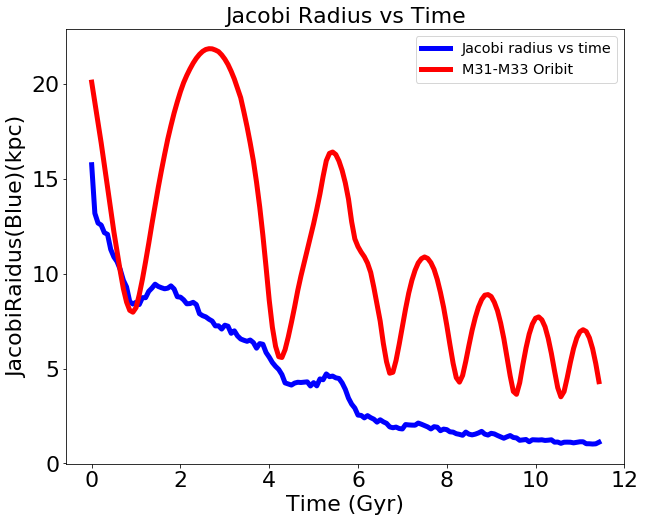

In [96]:
# Plot the Jacobi Radius vs Time simulation 
#################################


fig, ax= plt.subplots(figsize=(10, 8))


# Plot the Jacobi Radius vs Time
ax.plot(M33JB_profile['t']/1e3, M33JB_profile['Ms'], color='blue', linewidth=5, label='Jacobi radius vs time')

# Plot the separtion of M33 and M31
plt.plot(M31_hw6orb['t'],PM_M31_M33/10, color='red', linewidth=5, label='M31-M33 Oribit')


# Add axis labels
plt.xlabel('Time (Gyr)', fontsize=22)
plt.ylabel('JacobiRaidus(Blue)(kpc)', fontsize=22)

# Set the title
ax.set_title("Jacobi Radius vs Time", fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')

# save 
fig.savefig('./ResultImage/JacobiRadiusVSTime.png')

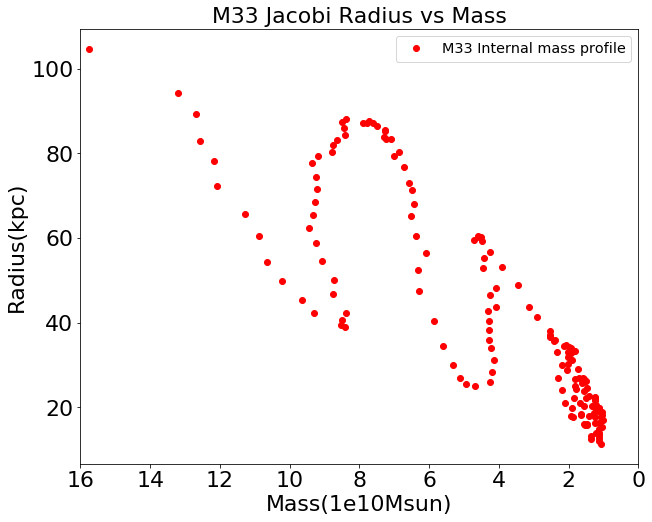

In [97]:
# Plot the Jacobi Radius vs Jacobi Mass simulation 
#################################


fig, ax= plt.subplots(figsize=(10, 8))


# Plot the Jacobi Radius vs Mass
ax.plot(M33JB_profile['Ms'], M33JB_profile['r_jb'], 'ro', linewidth=5, label='M33 Internal mass profile')


# Add axis labels
plt.xlabel('Mass(1e10Msun)', fontsize=22)
plt.ylabel('Radius(kpc)', fontsize=22)

# Set the title
ax.set_title("M33 Jacobi Radius vs Mass", fontsize=22)

ax.set(xlim=(16, 0))
#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')

# save 
fig.savefig('./ResultImage/M33JacobiRadiusVSMass.png')

In [39]:
M33JB_profile.shape

(161,)

In [50]:
#Set several empty arrays
#      Arrays:Massloss
#             Massloss Rate
#             Change of time for Massloss
#             Average time between one snap file and the next
#             The cummulative Mass loss fraction
Massloss = []
Masslossrate = []
MasslossdT = []
AverageTime = []
cumulativeMasslossfraction=[]

#The for loop is going to calculate massloss, massloss rate, change of time in Massloss, 
#average time, and cumulative mass fraction

for i in range(len(M33JB_profile)):
    #print(i)
    if i > 0:
        Massloss.append(M33JB_profile['Ms'][i]-M33JB_profile['Ms'][i-1])
        MasslossdT.append(M33JB_profile['t'][i]/1e3 -M33JB_profile['t'][i-1]/1e3)
        AverageTime.append((M33JB_profile['t'][i]/1e3 + M33JB_profile['t'][i-1]/1e3)/2)
        Masslossrate.append(Massloss[i-1]/MasslossdT[i-1])
        cumulativeMasslossfraction.append((M33JB_profile['Ms'][0]-M33JB_profile['Ms'][i])/M33JB_profile['Ms'][0])
    
       

In [49]:
#Test the size of one of these arrays
np.size(Masslossrate)

160

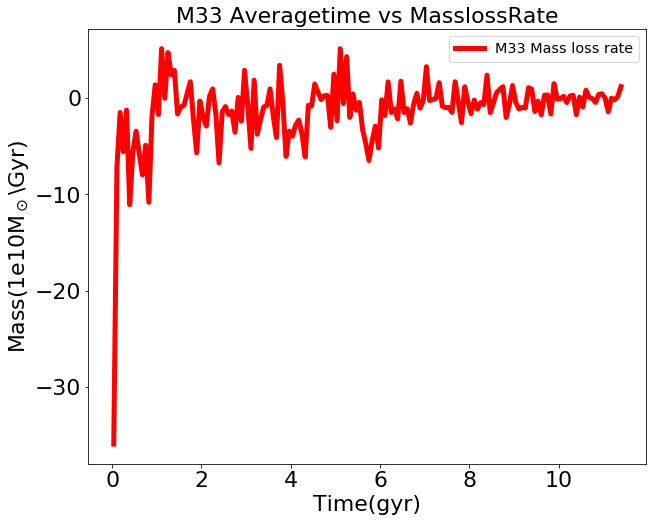

In [98]:
# Plot the MassLoss rate 
#################################


fig, ax= plt.subplots(figsize=(10, 8))


# Plot the Average time vs Masslossrate
ax.plot(AverageTime, Masslossrate, 'r-', linewidth=5, label='M33 Mass loss rate')




# Add axis labels
plt.xlabel('Time(gyr)', fontsize=22)
plt.ylabel('Mass(1e10M$_\odot$\Gyr)', fontsize=22)

# Set the title
ax.set_title("M33 Averagetime vs MasslossRate", fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')

# save 
fig.savefig('./ResultImage/M33MassLossRate.png')

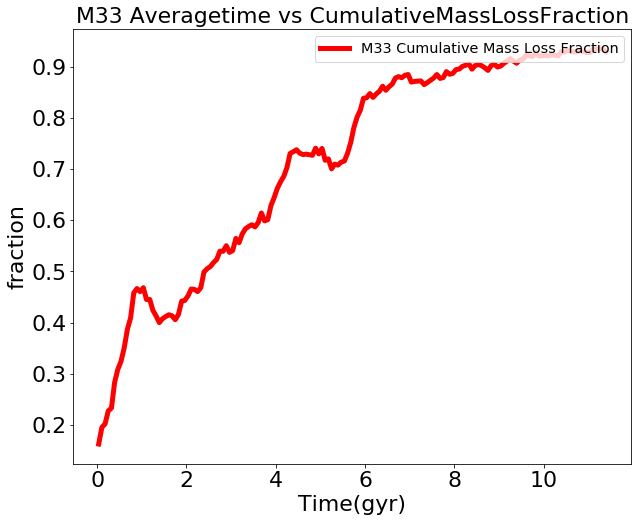

In [99]:
# Plot the cumulative Massloss fraction
#################################


fig, ax= plt.subplots(figsize=(10, 8))


# Plot the cumulative Massloss fraction vs average time
ax.plot(AverageTime, cumulativeMasslossfraction, 'r-', linewidth=5, label='M33 Cumulative Mass Loss Fraction')

# Add axis labels
plt.xlabel('Time(gyr)', fontsize=22)
plt.ylabel('fraction', fontsize=22)

# Set the title
ax.set_title("M33 Averagetime vs CumulativeMassLossFraction", fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')

# save 
fig.savefig('./ResultImage/CumulativeMasslossfractionvsTime.png')

In [2]:
#Here I have picked 4 examples from VLowRes document, 
#they are snapshots:0,300,580,800
S0 = MassProfile('./simple_mp/M33S0',0)
S300 = MassProfile('./simple_mp/M33S300',0)
S580 = MassProfile('./simple_mp/M33S580',0)
S800 = MassProfile('./simple_mp/M33S800',0)

In [73]:
# Create an array to store Radius, from 0-50 kpc
# intervals of 0.5 kpc
R = np.arange(0.1,100,0.5)

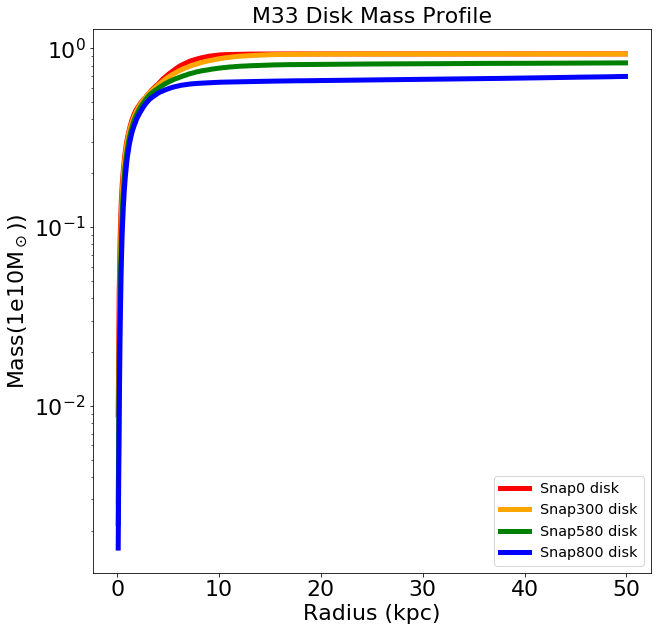

In [100]:
# Plot the disk Mass Profile for M33.
####################################


fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot disk mass profile Snaoshot0
plt.semilogy(R,S0.MassEnclosed(2,R)/1e10, color='red', linewidth=5, label='Snap0 disk')


# Plot disk mass profile Snaoshot300
plt.semilogy(R,S300.MassEnclosed(2,R)/1e10, color='orange', linewidth=5, label='Snap300 disk')


# Plot disk mass profile Snaoshot580
plt.semilogy(R,S580.MassEnclosed(2,R)/1e10, color='green', linewidth=5, label='Snap580 disk')

# Plot disk mass profile Snaoshot800
plt.semilogy(R,S800.MassEnclosed(2,R)/1e10, color='blue', linewidth=5, label='Snap800 disk')


# Add axis labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('Mass(1e10M$_\odot$))', fontsize=22)

#set axis limits

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
#plt.rcParams.update[{'font.size':20}]

# add a legend with some customizations.
legend = ax.legend(loc='best',fontsize='x-large')

#add figure text
ax.set_title('M33 Disk Mass Profile', fontsize=22)


# Save to a file
ax.set_rasterized(True)
plt.savefig('./ResultImage/MassProfile_M33Disk.png', rasterized=True, dpi=350)

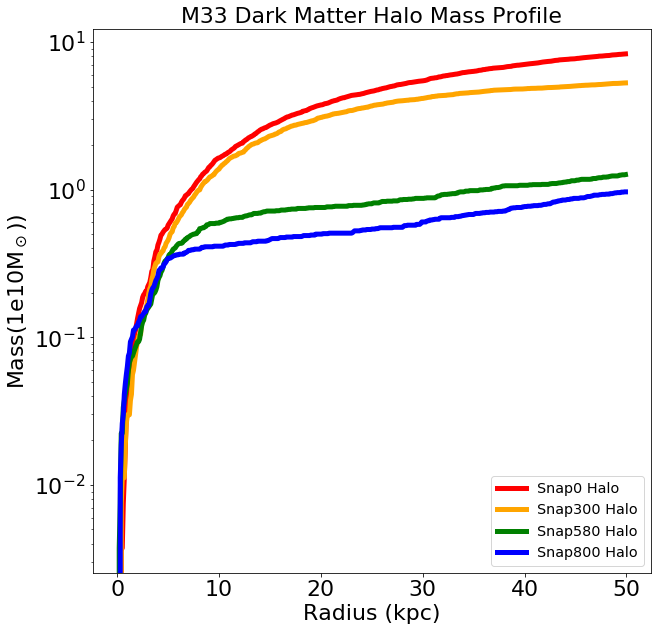

In [101]:
# Plot the halo Mass Profile for M33.
####################################
R = np.arange(0.1,50,0.1)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot halo mass profile for Snaoshot0
plt.semilogy(R,S0.MassEnclosed(1,R)/1e10, color='red', linewidth=5, label='Snap0 Halo')


# Plot halo mass profile for Snaoshot300
plt.semilogy(R,S300.MassEnclosed(1,R)/1e10, color='orange', linewidth=5, label='Snap300 Halo')


# Plot halo mass profile for Snaoshot580
plt.semilogy(R,S580.MassEnclosed(1,R)/1e10, color='green', linewidth=5, label='Snap580 Halo')

# Plot halo mass profile for Snaoshot800
plt.semilogy(R,S800.MassEnclosed(1,R)/1e10, color='blue', linewidth=5, label='Snap800 Halo')


# Add axis labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('Mass(1e10M$_\odot$))', fontsize=22)

#set axis limits

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
#plt.rcParams.update[{'font.size':20}]

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

#add figure text
ax.set_title('M33 Dark Matter Halo Mass Profile', fontsize=22)


# Save to a file
ax.set_rasterized(True)
plt.savefig('./ResultImage/MassProfile_M33Halo.png', rasterized=True, dpi=350)

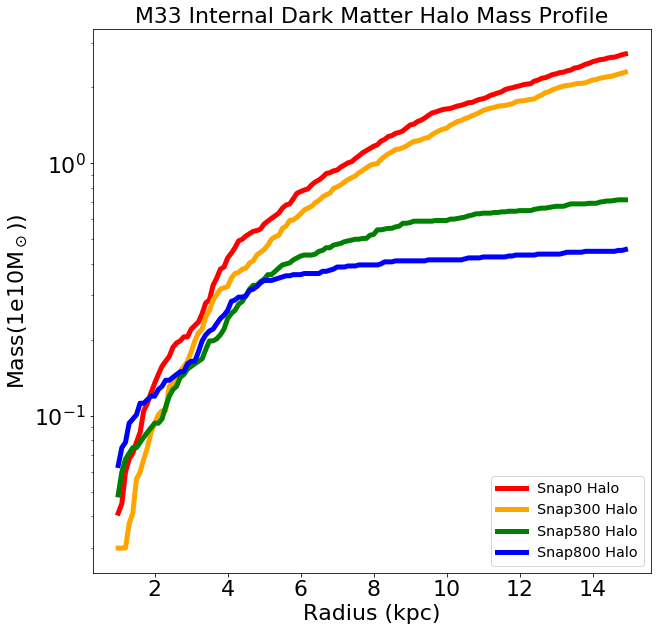

In [8]:
# Plot the halo Mass Profile for M33.
####################################
R = np.arange(1,15,0.1)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot halo mass profile for Snaoshot0
plt.semilogy(R,S0.MassEnclosed(1,R)/1e10, color='red', linewidth=5, label='Snap0 Halo')


# Plot halo mass profile for Snaoshot300
plt.semilogy(R,S300.MassEnclosed(1,R)/1e10, color='orange', linewidth=5, label='Snap300 Halo')


# Plot halo mass profile for Snaoshot580
plt.semilogy(R,S580.MassEnclosed(1,R)/1e10, color='green', linewidth=5, label='Snap580 Halo')

# Plot halo mass profile for Snaoshot800
plt.semilogy(R,S800.MassEnclosed(1,R)/1e10, color='blue', linewidth=5, label='Snap800 Halo')


# Add axis labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('Mass(1e10M$_\odot$))', fontsize=22)

#set axis limits

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
#plt.rcParams.update[{'font.size':20}]

# add a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

#add figure text
ax.set_title('M33 Internal Dark Matter Halo Mass Profile', fontsize=22)


# Save to a file
ax.set_rasterized(True)
plt.savefig('./ResultImage/MassProfile_InternalM33Halo.png', rasterized=True, dpi=350)

In [79]:
#Here I have picked 4 examples from HighRes document, to see how does internal mass profile change
#they are snapshots:0,300,580,800
#And use the stellar disk profile to calculate the density profile
sdp0 = SurfaceDensityProfile("HighRes_sample/","M33", 0, radii = np.arange(0.01,5,0.1))
sdp1 = SurfaceDensityProfile("HighRes_sample/","M33", 300,radii = np.arange(0.01,5,0.1))
sdp2 = SurfaceDensityProfile("HighRes_sample/","M33", 580,radii = np.arange(0.01,5,0.1))
sdp3 = SurfaceDensityProfile("HighRes_sample/","M33", 800,radii = np.arange(0.01,5,0.1))

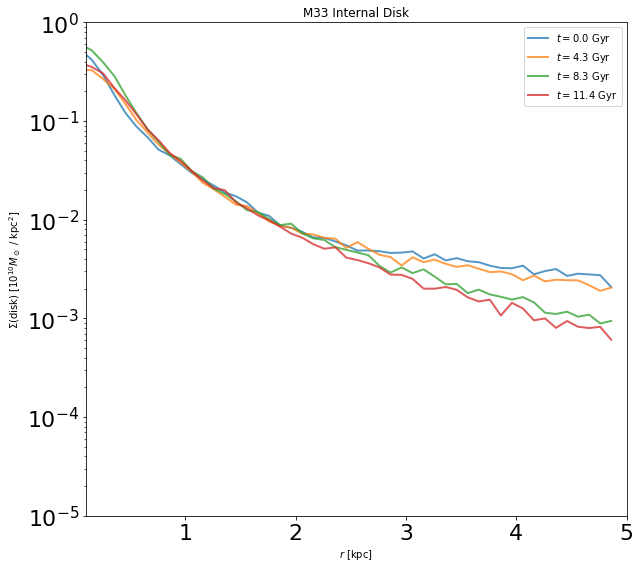

In [102]:
# plot the surface density profiles of the M33 disk
fig, ax = plt.subplots(figsize=(9, 8))
ax.semilogy(sdp0.r_annuli, sdp0.Sigma, label="$t={:.1f}$ Gyr".format(sdp0.com.time.value/1e3), lw=2, alpha=0.75)
ax.semilogy(sdp1.r_annuli, sdp1.Sigma, label="$t={:.1f}$ Gyr".format(sdp1.com.time.value/1e3), lw=2, alpha=0.75)
ax.semilogy(sdp2.r_annuli, sdp2.Sigma, label="$t={:.1f}$ Gyr".format(sdp2.com.time.value/1e3), lw=2, alpha=0.75)
ax.semilogy(sdp3.r_annuli, sdp3.Sigma, label="$t={:.1f}$ Gyr".format(sdp3.com.time.value/1e3), lw=2, alpha=0.75)
ax.set(xlabel=r"$r$ [kpc]", ylabel=r"$\Sigma$(disk) [$10^{10} M_\odot$ / kpc$^2$]", title="M33 Internal Disk", 
       xlim=( 0.1,5), ylim=(1e-5, 1))
ax.legend(loc='best'); fig.tight_layout()
plt.savefig('./ResultImage/M33InternalDiskDensity.png', rasterized=True, dpi=350)

In [81]:
#Here I have picked 4 examples from VLowRes document, 
#they are snapshots:0,300,580,800
High_S0 = MassProfile('./HighRes_sample/M33H1',0)
High_S300 = MassProfile('./HighRes_sample/M33H2',0)
High_S580 = MassProfile('./HighRes_sample/M33H3',0)
High_S800 = MassProfile('./HighRes_sample/M33H4',0)

In [82]:
# Create an array to store HighRes Radius, from 0-10 kpc
# intervals of 0.5 kpc
r_hr = np.arange(0.1,15,0.01)
ScaleM33 = 25
MtotM33 = 0.187e12

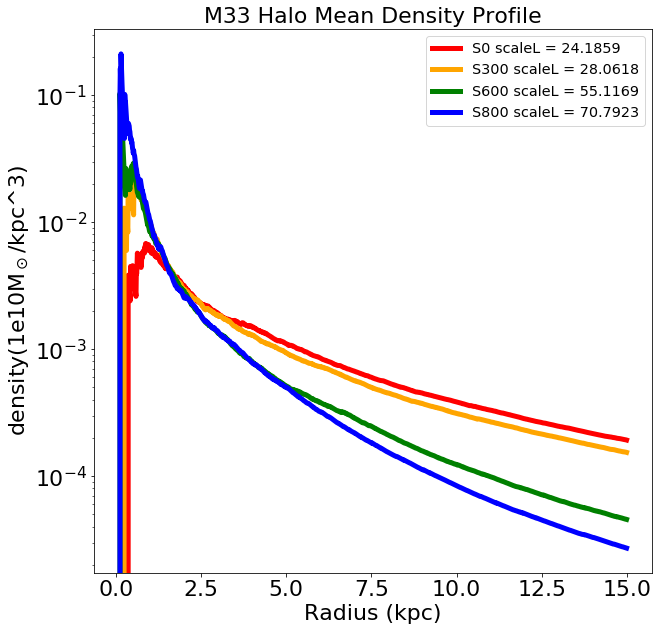

In [103]:
# Plot the internal halo density Profile for M33.
####################################


fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot mean halo mass density for Snaoshot0
plt.semilogy(r_hr,High_S0.MassEnclosed(1,r_hr)/((4/3)*np.pi*r_hr**3*1e10), color='red', linewidth=5, label='S0 scaleL = 24.1859')


# Plot mean halo mass density for Snaoshot300
plt.semilogy(r_hr,High_S300.MassEnclosed(1,r_hr)/((4/3)*np.pi*r_hr**3*1e10), color='orange', linewidth=5, label='S300 scaleL = 28.0618')


# Plot mean halo mass density for Snaoshot580
plt.semilogy(r_hr,High_S580.MassEnclosed(1,r_hr)/((4/3)*np.pi*r_hr**3*1e10), color='green', linewidth=5, label='S600 scaleL = 55.1169')

# Plot mean halo mass density for Snaoshot800
plt.semilogy(r_hr,High_S800.MassEnclosed(1,r_hr)/((4/3)*np.pi*r_hr**3*1e10), color='blue', linewidth=5, label='S800 scaleL = 70.7923')


# Add axis labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('density(1e10M$_\odot$/kpc^3)', fontsize=22)

#set axis limits

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
#plt.rcParams.update[{'font.size':20}]

# add a legend with some customizations.
legend = ax.legend(loc='best',fontsize='x-large')

#add figure text
ax.set_title('M33 Halo Mean Density Profile', fontsize=22)


# Save to a file
ax.set_rasterized(True)
plt.savefig('./ResultImage/M33InternalMeanDensityProfile.png', rasterized=True, dpi=350)

In [84]:
def BestFitScaleRadius(name):
    """ Find the scale radius that gives the best-fit Hernquist profile """
    # generate a list of radii from 0.1 to 15 kpc
    r = np.arange(0.1, 15, 0.01)
    # calculate the enclosed halo mass along r
    m_enc_halo = name.MassEnclosed(1, r).value / 1e10
    # use 30 kpc as an initial guess
    # use least_squares to find the best-fit scale radius "a"
    # by minimizing the difference between m_enc_halo and Hernquist mass
    # fitting is performed in units of 1e10 * Msun to increase accuracy
    d = lambda a : name.HernquistMass(r, a, 0.187e12).value / 1e10 - m_enc_halo
    res_lsq = least_squares(d, 30, loss='soft_l1')
    # check if fitting is successful
    if res_lsq.success:
        return np.squeeze(res_lsq.x)
    else:
        raise RuntimeError("Fitting failed; message:", res_leq.message,", cost function:", res_leq.cost)

In [85]:
best_fit_number1 = BestFitScaleRadius(High_S0)
best_fit_number2 = BestFitScaleRadius(High_S300)
best_fit_number3 = BestFitScaleRadius(High_S580)
best_fit_number4 = BestFitScaleRadius(High_S800)
print(best_fit_number1,best_fit_number2,best_fit_number3,best_fit_number4)

24.185987705980736 28.061822923803124 55.116959819443544 70.7923396482765


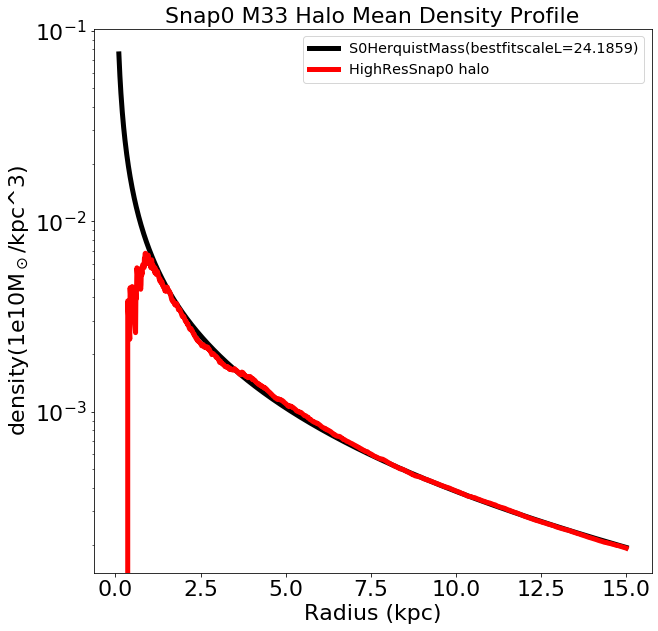

In [105]:
#Plot in herquist mass profile to justify it
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot hernquist mean halo mass density for Snaoshot0
plt.semilogy(r_hr,High_S0.HernquistMass(r_hr,24.185987,MtotM33)/((4/3)*np.pi*r_hr**3*1e10), color='black', linewidth=5, label='S0HerquistMass(bestfitscaleL=24.1859)')  



# Plot mean halo mass density for Snaoshot0
plt.semilogy(r_hr,High_S0.MassEnclosed(1,r_hr)/((4/3)*np.pi*r_hr**3*1e10), color='red', linewidth=5, label='HighResSnap0 halo')

# Add axis labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('density(1e10M$_\odot$/kpc^3)', fontsize=22)

#set axis limits

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='best',fontsize='x-large')

#add figure text
ax.set_title('Snap0 M33 Halo Mean Density Profile', fontsize=22)


# Save to a file
ax.set_rasterized(True)
plt.savefig('./ResultImage/Snapshot0EnclosedvsHernquistMeanDensity.png', rasterized=True, dpi=350)

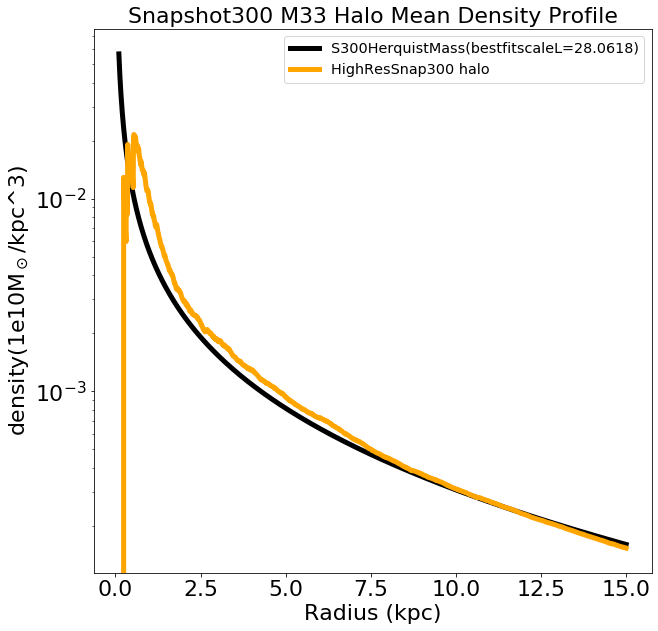

In [107]:
#Plot in herquist mass profile to justify it
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot hernquist mean halo mass density for Snaoshot300
plt.semilogy(r_hr,High_S300.HernquistMass(r_hr,28.06182,MtotM33)/((4/3)*np.pi*r_hr**3*1e10), color='black', linewidth=5, label='S300HerquistMass(bestfitscaleL=28.0618)')  



# Plot mean halo mass density for Snaoshot300
plt.semilogy(r_hr,High_S300.MassEnclosed(1,r_hr)/((4/3)*np.pi*r_hr**3*1e10), color='orange', linewidth=5, label='HighResSnap300 halo')

# Add axis labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('density(1e10M$_\odot$/kpc^3)', fontsize=22)

#set axis limits

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


# add a legend with some customizations.
legend = ax.legend(loc='best',fontsize='x-large')

#add figure text
ax.set_title('Snapshot300 M33 Halo Mean Density Profile', fontsize=22)


# Save to a file
ax.set_rasterized(True)
plt.savefig('Snapshot300EnclosedvsHernquistMeanDensity.png', rasterized=True, dpi=350)

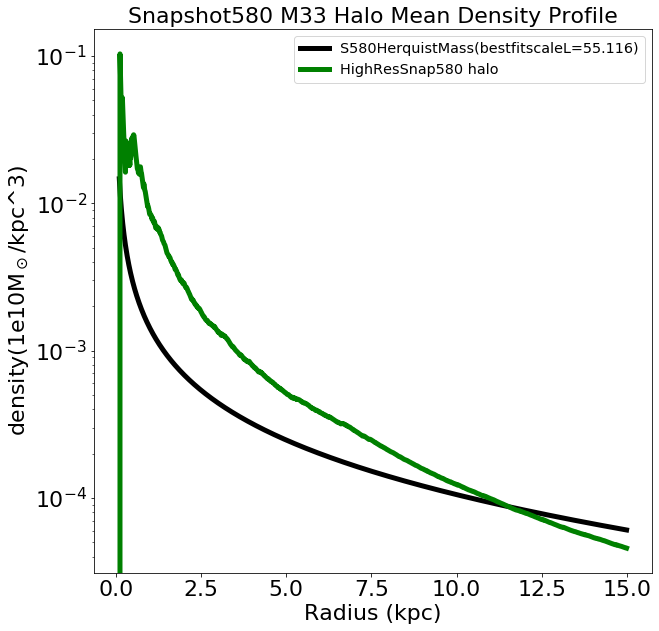

In [108]:
#Plot in herquist mass profile to justify it
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot hernquist mean halo mass density for Snaoshot580
plt.semilogy(r_hr,High_S580.HernquistMass(r_hr,55.116,MtotM33)/((4/3)*np.pi*r_hr**3*1e10), color='black', linewidth=5, label='S580HerquistMass(bestfitscaleL=55.116)')  



# Plot mean halo mass density Snaoshot580
plt.semilogy(r_hr,High_S580.MassEnclosed(1,r_hr)/((4/3)*np.pi*r_hr**3*1e10), color='green', linewidth=5, label='HighResSnap580 halo')

# Add axis labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('density(1e10M$_\odot$/kpc^3)', fontsize=22)

#set axis limits

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='best',fontsize='x-large')

#add figure text
ax.set_title('Snapshot580 M33 Halo Mean Density Profile', fontsize=22)


# Save to a file
ax.set_rasterized(True)
plt.savefig('./ResultImage/Snapshot580EnclosedVsHernquistMeanDensity.png', rasterized=True, dpi=350)

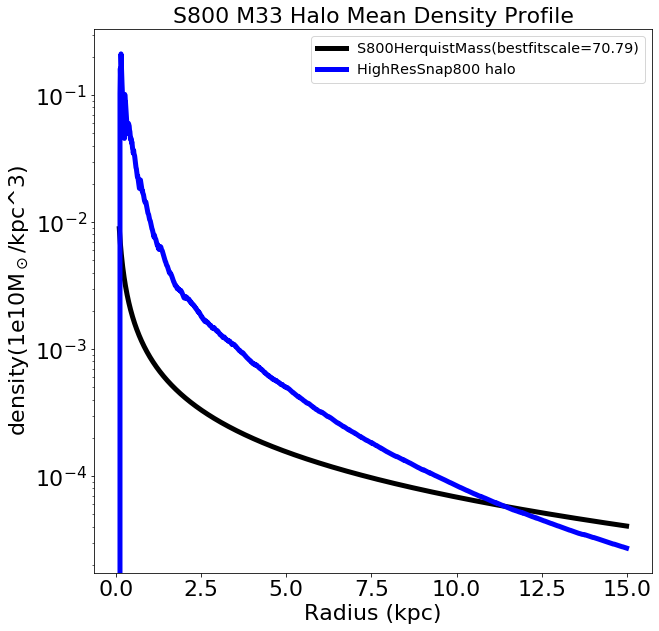

In [109]:
#Plot in herquist mass profile to justify it
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

# Plot hernquist mean halo mass density for Snaoshot800
plt.semilogy(r_hr,High_S800.HernquistMass(r_hr,70.79,MtotM33)/((4/3)*np.pi*r_hr**3*1e10), color='black', linewidth=5, label='S800HerquistMass(bestfitscale=70.79)')  



# Plot mean halo mass density for Snaoshot800
plt.semilogy(r_hr,High_S800.MassEnclosed(1,r_hr)/((4/3)*np.pi*r_hr**3*1e10), color='blue', linewidth=5, label='HighResSnap800 halo')

# Add axis labels
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('density(1e10M$_\odot$/kpc^3)', fontsize=22)

#set axis limits

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size


# add a legend with some customizations.
legend = ax.legend(loc='best',fontsize='x-large')

#add figure text
ax.set_title('S800 M33 Halo Mean Density Profile', fontsize=22)


# Save to a file
ax.set_rasterized(True)
plt.savefig('./ResultImage/Snapshot800EnclosedVsHernquistMeanDensity.png', rasterized=True, dpi=350)